### SGA Fitting Analysis

The purpose of this notebook is to assess the SGA fitting results and to identify any additional problems.

In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table
from legacyhalos.misc import imagetool_inspect, viewer_inspect
from legacyhalos.SGA import read_sample, ELLIPSEBITS, DROPBITS
from astrometry.util.starutil_numpy import arcsec_between
from astrometry.libkd.spherematch import match_radec

In [2]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.2)
import matplotlib.pyplot as plt
%matplotlib inline

### Read the data

In [3]:
%env LEGACYHALOS_DIR=/global/cfs/cdirs/desi/users/ioannis/SGA
%env LEGACYHALOS_DATA_DIR=/global/cscratch1/sd/ioannis/SGA-data-dr9alpha/

env: LEGACYHALOS_DIR=/global/cfs/cdirs/desi/users/ioannis/SGA
env: LEGACYHALOS_DATA_DIR=/global/cscratch1/sd/ioannis/SGA-data-dr9alpha/


In [4]:
ellipsefile = os.path.join(os.getenv('LEGACYHALOS_DATA_DIR'), 'SGA-ellipse-v3.0.fits')
kdellipsefile = os.path.join(os.getenv('LEGACYHALOS_DATA_DIR'), 'SGA-ellipse-v3.0.kd.fits')
dropcatfile = os.path.join(os.getenv('LEGACYHALOS_DATA_DIR'), 'SGA-dropped-v3.0.fits')

In [5]:
%time sample = read_sample(verbose=False, preselect_sample=True)
%time fullsample = read_sample(verbose=False, preselect_sample=False)

Selecting 379090 galaxies in the DR9 footprint.
CPU times: user 2.59 s, sys: 342 ms, total: 2.93 s
Wall time: 3.07 s
CPU times: user 513 ms, sys: 163 ms, total: 677 ms
Wall time: 730 ms


In [6]:
%time ellipse = Table(fitsio.read(ellipsefile))
print('Read {} galaxies from {}'.format(len(ellipse), ellipsefile))

CPU times: user 28 s, sys: 10.4 s, total: 38.4 s
Wall time: 38.6 s
Read 3131971 galaxies from /global/cscratch1/sd/ioannis/SGA-data-dr9alpha/SGA-ellipse-v3.0.fits


In [7]:
%time dropcat = Table(fitsio.read(dropcatfile))
print('Read {} galaxies from {}'.format(len(dropcat), dropcatfile))
assert(np.all(dropcat['ELLIPSEBIT'] == 0))

CPU times: user 15.5 ms, sys: 3.8 ms, total: 19.3 ms
Wall time: 131 ms
Read 9700 galaxies from /global/cscratch1/sd/ioannis/SGA-data-dr9alpha/SGA-dropped-v3.0.fits


## Study the galaxies that are "dropped".

Galaxies can end up in this catalog for several different reasons:

```python
DROPBITS = dict(
    notfit = 2**0,    # no Tractor catalog, not fit
    nogrz = 2**1,     # missing grz coverage
    masked = 2**2,    # masked (e.g., due to a bleed trail)
    dropped = 2**3,   # dropped by Tractor (either spurious or a problem with the fitting)
    isPSF = 2**4,     # tractor type=PSF
    veto = 2**5,      # veto the ellipse-fit geometry
    negflux = 2**6,   # flux_r <= 0
    )
```

Note that all the genuinely spurious sources have been culled from the parent sample; therefore, all objects in the *dropcat* sample (regardless of the reason) should be kept in the SGA as unfitted sources.

##### Summarize the number galaxies with each bit.

In [8]:
for bitname in DROPBITS.keys():
    ww = np.where(dropcat['DROPBIT'] & DROPBITS[bitname] != 0)[0]
    if len(ww) > 0:
        print('dropcat: {}, N={}'.format(bitname, len(ww)))
        #print(dropcat[ww]['SGA_ID', 'GALAXY', 'RA', 'DEC', 'DROPBIT'])

dropcat: notfit, N=1
dropcat: nogrz, N=9237
dropcat: masked, N=395
dropcat: isPSF, N=12
dropcat: veto, N=55


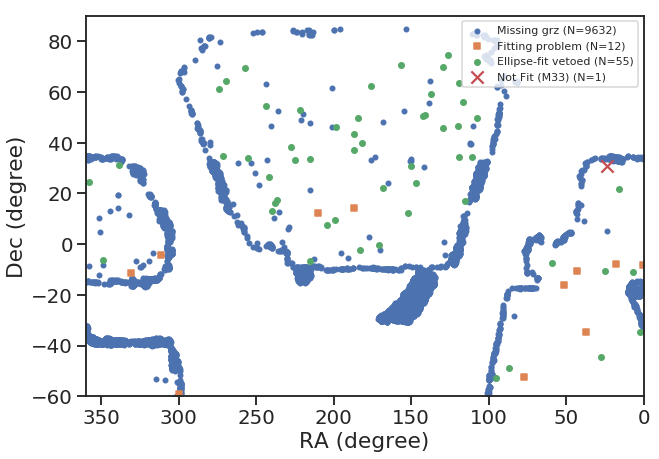

In [9]:
notfit = np.where(dropcat['DROPBIT'] & DROPBITS['notfit'] != 0)[0]
veto = np.where(dropcat['DROPBIT'] & DROPBITS['veto'] != 0)[0]
nogrz = np.where(np.logical_or(
    dropcat['DROPBIT'] & DROPBITS['nogrz'] != 0,
    dropcat['DROPBIT'] & DROPBITS['masked'] != 0))[0]
iPSF = dropcat['DROPBIT'] & DROPBITS['isPSF'] != 0
dropped = dropcat['DROPBIT'] & DROPBITS['dropped'] != 0
other = np.logical_or(iPSF, dropped)# * dropcat['DEC'] > 30)
#other = np.logical_or(other, dropcat['DROPBIT'] & DROPBITS['masked'] != 0)
#other = np.logical_or(other, dropcat['DROPBIT'] & DROPBITS['negflux'] != 0)
other = np.where(other)[0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(dropcat['RA'][nogrz], dropcat['DEC'][nogrz], 
           s=20, label='Missing grz (N={})'.format(len(nogrz)))
ax.scatter(dropcat['RA'][other], dropcat['DEC'][other], 
           s=30, marker='s', label='Fitting problem (N={})'.format(len(other)))
ax.scatter(dropcat['RA'][veto], dropcat['DEC'][veto], 
           s=30, marker='o', label='Ellipse-fit vetoed (N={})'.format(len(veto)))
ax.scatter(dropcat['RA'][notfit], dropcat['DEC'][notfit], 
           s=150, marker='x', label='Not Fit (M33) (N={})'.format(len(notfit)))
ax.set_xlabel('RA (degree)')
ax.set_ylabel('Dec (degree)')
ax.set_xlim(360, 0)
ax.set_ylim(-60, 90)    
_ = ax.legend(fontsize=11, loc='upper right')

##### Investigate the *notfit* and *fitting problem* samples--

In [10]:
#[print(gg) for gg in set(dropcat[notfit]['GROUP_NAME'])]
#rr = dropcat[notfit]
dropcat[notfit]
#from legacyhalos.SGA import get_raslice
#rr = dropcat[notfit]
#[print(gg) for gg in set(rr['GROUP_NAME'])]
#[get_raslice(ra) for ra in rr['RA']]
#print(raslice)

INDEX,SGA_ID,GALAXY,PGC,RA,DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT
int64,int64,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,bool,bool,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float32,bytes4,float32,float32,int32,int32
357110,972325,NGC0598,5818,23.462120999999996,30.659925199999996,Sc,22.67,62.086903,0.5915616,-0.00060808734,23.94448,6.351,False,LEDA-20181114,True,True,345318,NGC0598_GROUP,3,True,23.461713020137164,30.662208518892047,62.22551,0233p307,62.086903,LEDA,22.67,0.5915616,0,1


In [11]:
# first three have been dropped, the last one will be refit with updated coordinates
dropcat[dropped]

INDEX,SGA_ID,GALAXY,PGC,RA,DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT
int64,int64,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,bool,bool,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float32,bytes4,float32,float32,int32,int32


In [12]:
viewer_inspect(dropcat[iPSF])
bb = dropcat[iPSF]['GALAXY', 'GROUP_NAME', 'GROUP_DIAMETER', 'RA', 'DEC']
#bb = bb[np.argsort(bb['GROUP_DIAMETER'])[::-1]]
#with open('south-ispsf.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in bb['GROUP_NAME']]
#viewer_inspect(bb)
dropcat[iPSF]['GROUP_NAME', 'GROUP_DIAMETER', 'RA', 'DEC',]#.write('south-ispsf2.txt', format='ascii.basic', overwrite=True)

Writing 12 objects to /global/homes/i/ioannis/tmp/viewer.fits


GROUP_NAME,GROUP_DIAMETER,RA,DEC
bytes35,float32,float64,float64
PGC1008099,0.38018936,0.054243,-8.1160806
PGC1012273,0.44668356,17.8947585,-7.835188900000001
PGC331659,0.36307806,36.5892,-63.5221
PGC199544,0.67608297,37.072461,-34.637648299999995
PGC975145,0.36307806,42.9085095,-10.6823291
PGC012798,2.6791682,51.35383850944605,-16.233994239635294
PGC444203,0.4168694,76.9513305,-52.420325399999996
PGC040819,1.5,186.823911,14.147368400000001
PGC1403344_GROUP,0.8047296,210.29941202795126,12.067980366536588


In [13]:
#imagetool_inspect(dropcat[other])
#viewer_inspect(dropcat[other][np.argsort(dropcat[other]['DIAM'])[::-1]])
#[print(gg) for gg in set(dropcat[other]['GROUP_NAME'])]
#ww = iPSF * (dropcat['DEC'] > 30)
#from legacyhalos.SGA import get_raslice
#dropcat[other][np.argsort(dropcat[other]['DIAM'])[::-1]]#.write('toinvestigate.fits', overwrite=True)
#[print(gg) for gg in set(rr['GROUP_NAME'])]
#raslice = []
#for ra1, ra2 in zip(rr['RA'], rr['SGA_RA']):
#    raslice1, raslice2 = get_raslice(ra1), get_raslice(ra2)
#    #print(raslice1, raslice2)
#    if raslice1 == '999':
#        raslice.append(raslice2)
#    else:
#        raslice.append(raslice1)
#raslice = np.array(raslice)
#' '.join(raslice)
#set(raslice)
#rr
#print(raslice)
#dropcat[other]#['GALAXY', 'RA', 'DEC', 'DROPBIT']
#dropcat[ww]

#### Investigate the *nogrz* sample--

In [14]:
#imagetool_inspect(dropcat[nogrz])
#with open('nogrz.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in set(dropcat[nogrz]['GROUP_NAME'])]
dropcat[nogrz]

INDEX,SGA_ID,GALAXY,PGC,RA,DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT
int64,int64,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,bool,bool,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float32,bytes4,float32,float32,int32,int32
12597,44258,PGC688264,688264,0.592869,-32.656222,,173.0,0.3981072,0.36307806,0.09860154,25.03848,18.41,False,LEDA-20181114,True,True,12597,PGC688264,1,True,0.592869,-32.656222,0.3981072,0004m327,0.3981072,LEDA,173.0,0.36307806,0,4
121627,335069,PGC696262,696262,0.4565565,-32.1454877,,17.0,0.45708823,0.2630268,0.1127013,24.878483,17.95,False,LEDA-20181114,True,False,121627,PGC696262,1,True,0.4565565,-32.1454877,0.45708823,0004m322,0.45708823,LEDA,17.0,0.2630268,0,2
122833,337931,PGC308102,308102,0.4947495,-66.02619440000001,,151.0,0.36307806,0.57543993,-99.0,23.82848,17.4,False,LEDA-20181114,True,True,122833,PGC308102,1,True,0.4947495,-66.02619440000001,0.36307806,0003m660,0.36307806,LEDA,151.0,0.57543993,0,2
192284,525474,IC5380,188,0.7064595,-66.1865922,Sab,131.6,0.8433348,0.43551186,-99.0,23.728481,15.47,False,LEDA-20181114,True,False,192284,IC5380,1,True,0.7064595,-66.1865922,0.8433348,0009m662,0.8433348,LEDA,131.6,0.43551186,0,2
257025,701971,PGC308334,308334,0.75435,-65.996902,,57.0,0.5248075,0.61659503,-99.0,24.228481,17.0,False,LEDA-20181114,True,True,257025,PGC308334,1,True,0.75435,-65.996902,0.5248075,0009m660,0.5248075,LEDA,57.0,0.61659503,0,2
309408,850809,PGC092826,92826,0.2063022896923466,-32.801268528570425,Sc,173.0,0.5662393,0.2004472,-99.0,25.44348,18.05,True,LEDA-20181114,True,True,309408,PGC092826,1,True,0.2063022896923466,-32.801268528570425,0.5662393,0001m327,0.5662393,LEDA,173.0,0.2004472,0,4
323604,882234,PGC700191,700191,0.787116,-31.8583507,,175.5,0.3981072,0.61659503,0.107698165,23.953482,17.325,False,LEDA-20181114,True,True,323604,PGC700191,1,True,0.787116,-31.8583507,0.3981072,0007m317,0.3981072,LEDA,175.5,0.61659503,0,2
373918,1023815,PGC2034048,2034048,0.5851845000000001,33.5342288,,135.41,0.34673685,0.76736146,0.13281088,24.131481,17.803,False,LEDA-20181114,True,True,373918,PGC2034048,1,True,0.5851845000000001,33.5342288,0.34673685,0004p335,0.34673685,LEDA,135.41,0.76736146,0,4
445978,1218944,PGC878616,878616,0.9616545000000001,-17.7190472,,159.0,0.40738028,0.52480745,-99.0,24.28848,17.61,False,LEDA-20181114,True,False,445978,PGC878616,1,True,0.9616545000000001,-17.7190472,0.40738028,0009m177,0.40738028,LEDA,159.0,0.52480745,0,2


## SGA

Now let's look at the full ellipse-fit catalog.

```python
ELLIPSEBITS = dict(
    largeshift = 2**0,      # >10-pixel shift in the flux-weighted center
    rex_toosmall = 2**1,    # type == REX & shape_r < 5
    notrex_toosmall = 2**2, # type != REX & shape_r < 2
    failed = 2**3,          # ellipse-fitting failed
    notfit = 2**4,          # not ellipse-fit
    indropcat = 2**5,       # in the dropcat catalog
    )
```

In [15]:
print('Number in SGA ellipse catalog: {}'.format(len(ellipse)))
print('Number of pre-burned SGA galaxies: {}'.format(np.sum(ellipse['PREBURNED']*(ellipse['SGA_ID'] >= 0))))
print('Number of SGA galaxies: {}'.format(np.sum(ellipse['SGA_ID'] >= 0)))

Number in SGA ellipse catalog: 3131971
Number of pre-burned SGA galaxies: 383565
Number of SGA galaxies: 531677


Ensure that all objects in the *dropcat* catalog are in the SGA, since the objects that were dropped (and not ellipse-fit) are fitting problems, not spurious sources.

In [16]:
#w1 = (ellipse['TYPE'] == 'PSF') * (ellipse['SGA_ID'] > -1) * (ellipse['DEC'] > 30)
#g1 = list(ellipse[w1]['GROUP_NAME'])

#w2 = (dropcat['DROPBIT'] & DROPBITS['dropped'] != 0) * (dropcat['DEC'] > 30)
#g2 = list(dropcat[w2]['GROUP_NAME'])

#gall = np.array(g1 + g2)
#gall = gall[np.logical_not(np.isin(gall, np.array(['NGC2820_GROUP', 'NGC3448_GROUP', 'NGC4010_GROUP', 
#                               'NGC4395', 'NGC6621_GROUP', 'NGC6667', 'PGC200358_GROUP'])))]
#with open('north-refit-ispsf-dropped.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in gall]
    
#gout = list(np.loadtxt('north-ellipse-outdated.txt', str))

#gall = set(g1 + g2 + gout)
#print(len(gall))

#with open('north-refit.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in gall]

In [17]:
#ww = np.where(ellipse['SGA_ID'] > -1)[0]
#bb = ellipse[ellipse['GROUP_PRIMARY']]
#ww = [gg == fullsample['GROUP_NAME'] for gg in list(gall)]
#bb = ellipse[ww][np.isin(ellipse[ww]['GROUP_NAME'], list(gall))]
#bb.write('north-refit.fits', overwrite=True)
#bb[np.argsort(bb['GROUP_DIAMETER'])[::-1]]

In [18]:
I = np.where(np.isin(ellipse['SGA_ID'], dropcat['SGA_ID']))[0]
assert(len(I) == len(dropcat))
assert(np.all(ellipse[I]['PREBURNED'] == False))
#ellipse[I][ellipse[I]['PREBURNED'] == True]['GALAXY', 'TYPE', 'RA', 'DEC', 'SHAPE_R', 'ELLIPSEBIT', 'DROPBIT', 'PREBURNED', 'FREEZE']

(-60, 90)

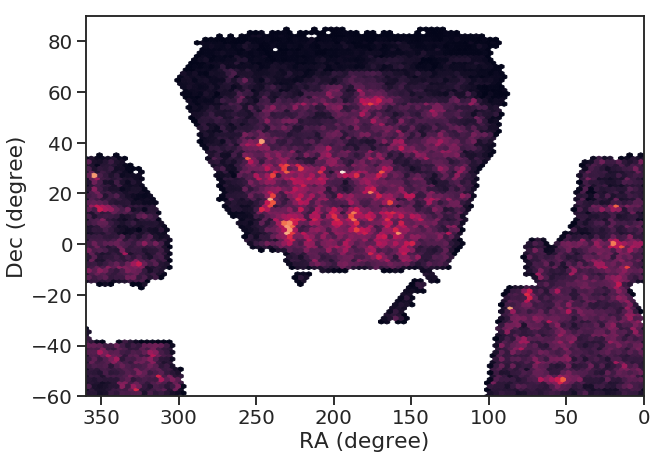

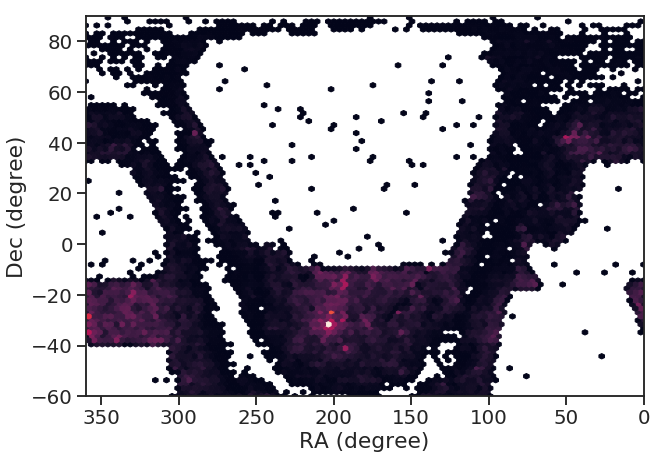

In [19]:
w1 = np.where((ellipse['SGA_ID'] > -1) * (ellipse['PREBURNED'] == True))[0]
w2 = np.where((ellipse['SGA_ID'] > -1) * (ellipse['PREBURNED'] == False))[0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.hexbin(ellipse['RA'][w1], ellipse['DEC'][w1], 
          mincnt=1, label='SGA - pre-burned')
ax.set_xlabel('RA (degree)')
ax.set_ylabel('Dec (degree)')
ax.set_xlim(360, 0)
ax.set_ylim(-60, 90)    
#_ = ax.legend(fontsize=11, loc='upper right')

fig, ax = plt.subplots(figsize=(10, 7))
ax.hexbin(ellipse['RA'][w2], ellipse['DEC'][w2], 
          mincnt=1, label='SGA - parent')
ax.set_xlabel('RA (degree)')
ax.set_ylabel('Dec (degree)')
ax.set_xlim(360, 0)
ax.set_ylim(-60, 90)    
#_ = ax.legend(fontsize=11, loc='upper right')

In [20]:
J = np.where((ellipse['PREBURNED'] == False) * (ellipse['SGA_ID'] >= 0))[0]
#plt.scatter(ellipse['RA'][J], ellipse['DEC'][J], s=1)
#ellipse['SGA_ID', 'GALAXY', 'RA', 'DEC', 'D25_LEDA', 'DIAM', 'DIAM_REF', 'PREBURNED'][J]
#jj[jj['GALAXY'] == 'NGC0598']

##### Which objects have not been fit or have failed?

In [21]:
#ellipse[np.isin(ellipse['SGA_ID'], dropcat['SGA_ID'][iPSF])]
#np.sum((ellipse['SGA_ID'] > -1) * (ellipse['TYPE'] == 'PSF'))

In [22]:
for bitname in ELLIPSEBITS.keys():
    ww = np.where(ellipse['ELLIPSEBIT'] & ELLIPSEBITS[bitname] != 0)[0]
    if len(ww) > 0:
        print('ellipse: {}, N={}'.format(bitname, len(ww)))
        #print(ellipse[ww]['SGA_ID', 'GALAXY', 'RA', 'DEC', 'ELLIPSEBIT'])

ellipse: rex_toosmall, N=4310
ellipse: notrex_toosmall, N=4105
ellipse: notfit, N=138436
ellipse: indropcat, N=9700


In [24]:
notfit = np.where((ellipse['ELLIPSEBIT'] & ELLIPSEBITS['notfit'] != 0) * 
                  (ellipse['DROPBIT'] & DROPBITS['nogrz'] == 0) * 
                  (ellipse['DROPBIT'] & DROPBITS['masked'] == 0) * 
                   ellipse['GROUP_PRIMARY'] * ellipse['IN_FOOTPRINT'])[0]
#ellipse[notfit]['GALAXY', 'D25_LEDA', 'DIAM', 'DIAM_REF']
ellipse[notfit]

SGA_ID,GALAXY,PGC,SGA_RA,SGA_DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT,RELEASE,BRICKID,OBJID,BRICK_PRIMARY,MASKBITS,ITERATIVE,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,BX,BY,DCHISQ [5],EBV,MJD_MIN,MJD_MAX,REF_CAT,REF_ID,PMRA,PMDEC,PARALLAX,PMRA_IVAR,PMDEC_IVAR,PARALLAX_IVAR,REF_EPOCH,GAIA_POINTSOURCE,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_G_N_OBS,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_N_OBS,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_N_OBS,GAIA_PHOT_VARIABLE_FLAG,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_ASTROMETRIC_EXCESS_NOISE_SIG,GAIA_ASTROMETRIC_N_OBS_AL,GAIA_ASTROMETRIC_N_GOOD_OBS_AL,GAIA_ASTROMETRIC_WEIGHT_AL,GAIA_DUPLICATED_SOURCE,GAIA_A_G_VAL,GAIA_E_BP_MIN_RP_VAL,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,APFLUX_G [8],APFLUX_R [8],APFLUX_Z [8],APFLUX_RESID_G [8],APFLUX_RESID_R [8],APFLUX_RESID_Z [8],APFLUX_BLOBRESID_G [8],APFLUX_BLOBRESID_R [8],APFLUX_BLOBRESID_Z [8],APFLUX_IVAR_G [8],APFLUX_IVAR_R [8],APFLUX_IVAR_Z [8],APFLUX_MASKED_G [8],APFLUX_MASKED_R [8],APFLUX_MASKED_Z [8],APFLUX_W1 [5],APFLUX_W2 [5],APFLUX_W3 [5],APFLUX_W4 [5],APFLUX_RESID_W1 [5],APFLUX_RESID_W2 [5],APFLUX_RESID_W3 [5],APFLUX_RESID_W4 [5],APFLUX_IVAR_W1 [5],APFLUX_IVAR_W2 [5],APFLUX_IVAR_W3 [5],APFLUX_IVAR_W4 [5],MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_G,RCHISQ_R,RCHISQ_Z,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,PSFDEPTH_W3,PSFDEPTH_W4,WISE_COADD_ID,WISE_X,WISE_Y,SERSIC,SERSIC_IVAR,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,RADIUS_SB22,RADIUS_SB22.5,RADIUS_SB23,RADIUS_SB23.5,RADIUS_SB24,RADIUS_SB24.5,RADIUS_SB25,RADIUS_SB25.5,RADIUS_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,G_MAG_TOT,R_MAG_TOT,Z_MAG_TOT,PREBURNED,FREEZE
int64,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,bool,bool,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float32,bytes4,float32,float32,int32,int32,int16,int32,int32,bool,int16,bool,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32

In [25]:
failed = np.where(ellipse['ELLIPSEBIT'] & ELLIPSEBITS['failed'] != 0)[0]
ellipse[failed]

SGA_ID,GALAXY,PGC,SGA_RA,SGA_DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT,RELEASE,BRICKID,OBJID,BRICK_PRIMARY,MASKBITS,ITERATIVE,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,BX,BY,DCHISQ [5],EBV,MJD_MIN,MJD_MAX,REF_CAT,REF_ID,PMRA,PMDEC,PARALLAX,PMRA_IVAR,PMDEC_IVAR,PARALLAX_IVAR,REF_EPOCH,GAIA_POINTSOURCE,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_G_N_OBS,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_N_OBS,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_N_OBS,GAIA_PHOT_VARIABLE_FLAG,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_ASTROMETRIC_EXCESS_NOISE_SIG,GAIA_ASTROMETRIC_N_OBS_AL,GAIA_ASTROMETRIC_N_GOOD_OBS_AL,GAIA_ASTROMETRIC_WEIGHT_AL,GAIA_DUPLICATED_SOURCE,GAIA_A_G_VAL,GAIA_E_BP_MIN_RP_VAL,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,APFLUX_G [8],APFLUX_R [8],APFLUX_Z [8],APFLUX_RESID_G [8],APFLUX_RESID_R [8],APFLUX_RESID_Z [8],APFLUX_BLOBRESID_G [8],APFLUX_BLOBRESID_R [8],APFLUX_BLOBRESID_Z [8],APFLUX_IVAR_G [8],APFLUX_IVAR_R [8],APFLUX_IVAR_Z [8],APFLUX_MASKED_G [8],APFLUX_MASKED_R [8],APFLUX_MASKED_Z [8],APFLUX_W1 [5],APFLUX_W2 [5],APFLUX_W3 [5],APFLUX_W4 [5],APFLUX_RESID_W1 [5],APFLUX_RESID_W2 [5],APFLUX_RESID_W3 [5],APFLUX_RESID_W4 [5],APFLUX_IVAR_W1 [5],APFLUX_IVAR_W2 [5],APFLUX_IVAR_W3 [5],APFLUX_IVAR_W4 [5],MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_G,RCHISQ_R,RCHISQ_Z,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,PSFDEPTH_W3,PSFDEPTH_W4,WISE_COADD_ID,WISE_X,WISE_Y,SERSIC,SERSIC_IVAR,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,RADIUS_SB22,RADIUS_SB22.5,RADIUS_SB23,RADIUS_SB23.5,RADIUS_SB24,RADIUS_SB24.5,RADIUS_SB25,RADIUS_SB25.5,RADIUS_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,G_MAG_TOT,R_MAG_TOT,Z_MAG_TOT,PREBURNED,FREEZE
int64,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,bool,bool,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float32,bytes4,float32,float32,int32,int32,int16,int32,int32,bool,int16,bool,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32

In [26]:
assert(np.all(ellipse['SGA_ID'][ellipse['REF_CAT'] == 'L3'] != -1))
#ellipse[(ellipse['REF_CAT'] == 'L3') * (ellipse['SGA_ID'] == -1)]
#ee[(ee['REF_CAT'] == 'L3') * (ee['SGA_ID'] == -1)]['RA', 'DEC', 'SGA_ID', 'GALAXY']
#ellipse[(ellipse['REF_CAT'] == 'L3') * (ellipse['SGA_ID'] == -1)]['RA', 'DEC', 'SGA_ID']
#ellipse[(ellipse['REF_CAT'] == 'L3') * (ellipse['TYPE'] == 'PSF')]['FREEZE']

#### Compare the ellipse-fit geometry to the initial (Hyperleda) geometry--

In [27]:
I = np.where(ellipse['PREBURNED']*(ellipse['SGA_ID'] >= 0))[0]
#np.median(ellipse['RADIUS_SB26'][I] / ellipse['RADIUS_SB25'][I])

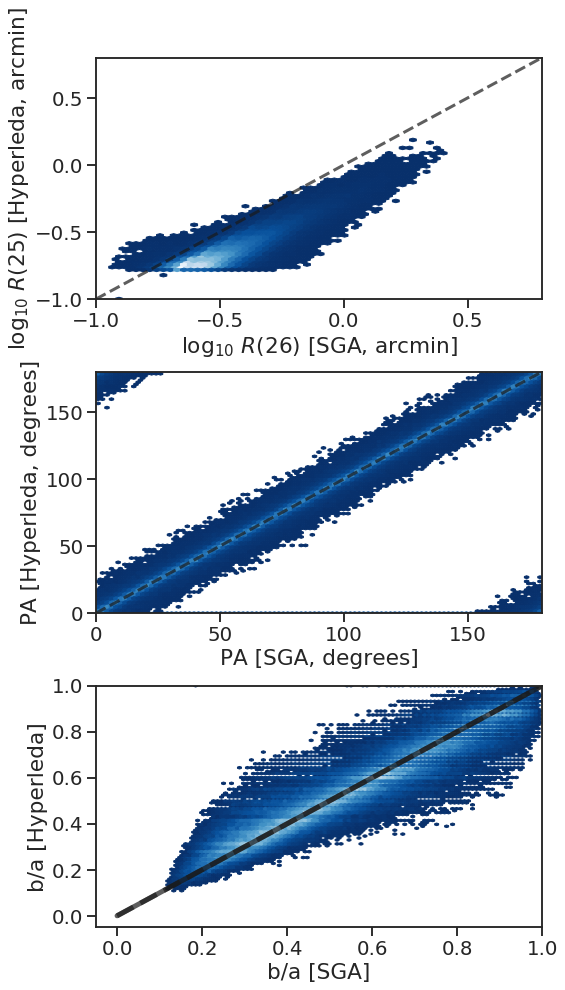

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16))
ax1.hexbin(np.log10(ellipse['DIAM'][I]/2), np.log10(ellipse['D25_LEDA'][I]/2), 
           mincnt=10, cmap=plt.cm.Blues_r)
#ax1.scatter(np.log10(lslga['D25']), np.log10(lslga['D25_ORIG']), s=15)
ax1.set_xlim(-1.0, 0.8)
ax1.set_ylim(-1.0, 0.8)
ax1.plot([-1, 1], [-1, 1], color='k', ls='--', lw=3, alpha=0.7)
ax1.set_xlabel(r'$\log_{10}\ R(26)$ [SGA, arcmin]')
ax1.set_ylabel(r'$\log_{10}\ R(25)$ [Hyperleda, arcmin]')

ax2.hexbin(ellipse['PA'][I], ellipse['PA_LEDA'][I], mincnt=10,
           cmap=plt.cm.Blues_r)
ax2.set_xlabel('PA [SGA, degrees]')
ax2.set_ylabel('PA [Hyperleda, degrees]')
ax2.plot([0, 180], [0, 180], color='k', ls='--', lw=3, alpha=0.7)

ax3.hexbin(ellipse['BA'][I], ellipse['BA_LEDA'][I], mincnt=10,
           cmap=plt.cm.Blues_r)
ax3.set_xlabel('b/a [SGA]')
ax3.set_ylabel('b/a [Hyperleda]')
ax3.plot([0, 1], [0, 1], color='k', ls='--', lw=5, alpha=0.7)
ax3.plot([0, 1], [0, 1], color='k', ls='-', lw=5, alpha=0.7)

fig.subplots_adjust(hspace=0.3)

REX 1.1938782
DEV 1.3176872
EXP 1.2188619
SER 1.2472342
Median over all types: 1.25044


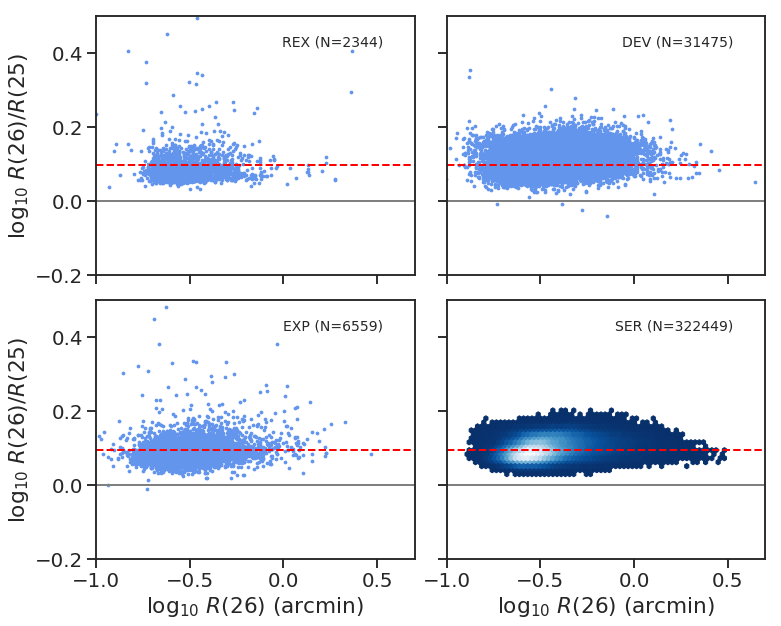

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)
for ax1, typ in zip(ax.flat, ['REX', 'DEV', 'EXP', 'SER']):
    ww = np.where((ellipse['TYPE'][I] == typ) * (ellipse['RADIUS_SB26'][I] > 0) *
                  (ellipse['RADIUS_SB25'][I] > 0))[0]
    xx = ellipse['RADIUS_SB26'][I][ww] / 60 
    yy = ellipse['RADIUS_SB26'][I][ww] / ellipse['RADIUS_SB25'][I][ww]
    print(typ, np.median(yy))
    ax1.set_xlim(-1, 0.7)
    ax1.set_ylim(-0.2, 0.5)
    ax1.axhline(y=0, ls='-', lw=2, color='gray')
    ax1.axhline(y=np.log10(1.25), ls='--', lw=2, color='red')
    if typ == 'SER':
        ax1.hexbin(np.log10(xx), np.log10(yy), mincnt=10, cmap=plt.cm.Blues_r)
    else:
        ax1.scatter(np.log10(xx), np.log10(yy), s=5, color='cornflowerblue')
    ax1.text(0.9, 0.9, '{} (N={})'.format(typ, len(ww)), 
             transform=ax1.transAxes, ha='right', va='center',
             fontsize=14)
ax[0, 0].set_ylabel(r'$\log_{10}\ R(26) / R(25)$')
ax[1, 0].set_ylabel(r'$\log_{10}\ R(26) / R(25)$')
ax[1, 0].set_xlabel(r'$\log_{10}\ R(26)$ (arcmin)')
ax[1, 1].set_xlabel(r'$\log_{10}\ R(26)$ (arcmin)')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ww = np.where((ellipse['RADIUS_SB26'][I] > 0) * (ellipse['RADIUS_SB25'][I] > 0))[0]
print('Median over all types: {:.5f}'.format(
    np.median(ellipse['RADIUS_SB26'][I][ww] / ellipse['RADIUS_SB25'][I][ww])))

REX 1.260373
DEV 1.5580947
EXP 1.362167
SER 1.4731627
Median over all types: 1.47595


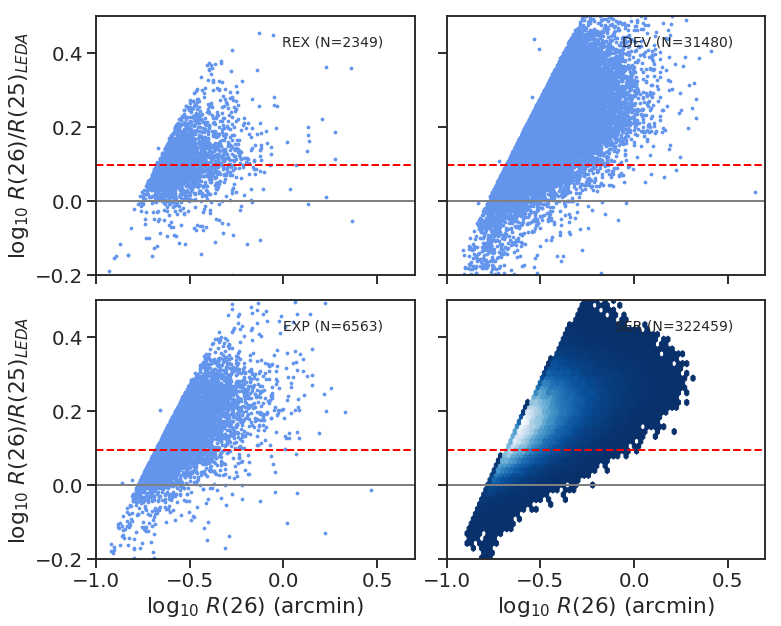

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)
for ax1, typ in zip(ax.flat, ['REX', 'DEV', 'EXP', 'SER']):
    ww = np.where((ellipse['TYPE'][I] == typ) * (ellipse['RADIUS_SB26'][I] > 0) *
                  (ellipse['D25_LEDA'][I] > 0))[0]
    xx = ellipse['RADIUS_SB26'][I][ww] / 60 
    yy = (ellipse['RADIUS_SB26'][I][ww] / 60) / (ellipse['D25_LEDA'][I][ww] / 2)
    print(typ, np.median(yy))
    ax1.set_xlim(-1, 0.7)
    ax1.set_ylim(-0.2, 0.5)
    ax1.axhline(y=0, ls='-', lw=2, color='gray')
    ax1.axhline(y=np.log10(1.25), ls='--', lw=2, color='red')
    if typ == 'SER':
        ax1.hexbin(np.log10(xx), np.log10(yy), mincnt=10, cmap=plt.cm.Blues_r)
    else:
        ax1.scatter(np.log10(xx), np.log10(yy), s=5, color='cornflowerblue')
    ax1.text(0.9, 0.9, '{} (N={})'.format(typ, len(ww)), 
             transform=ax1.transAxes, ha='right', va='center',
             fontsize=14)
ax[0, 0].set_ylabel(r'$\log_{10}\ R(26) / R(25)_{LEDA}$')
ax[1, 0].set_ylabel(r'$\log_{10}\ R(26) / R(25)_{LEDA}$')
ax[1, 0].set_xlabel(r'$\log_{10}\ R(26)$ (arcmin)')
ax[1, 1].set_xlabel(r'$\log_{10}\ R(26)$ (arcmin)')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ww = np.where((ellipse['RADIUS_SB26'][I] > 0) * (ellipse['D25_LEDA'][I] > 0))[0]
print('Median over all types: {:.5f}'.format(
    np.median((ellipse['RADIUS_SB26'][I][ww] / 60) / (ellipse['D25_LEDA'][I][ww] / 2))))

### Analyze the SGA galaxies with close pairs.

In [31]:
ellipse_sga = ellipse[(ellipse['SGA_ID'] > -1) * ellipse['PREBURNED']]
ellipse_notsga = ellipse[(ellipse['SGA_ID'] == -1) * ellipse['PREBURNED']]

def close_pairs():    
    I = match_radec(ellipse_sga['RA'], ellipse_sga['DEC'], ellipse_notsga['RA'],
                    ellipse_notsga['DEC'], 2./3600., indexlist=True)

    isga = []
    inotsga = []
    for ii, jj in enumerate(I):
        if jj is None:
            continue
        isga.append(ii)
        flux = ellipse_notsga['FLUX_R'][np.array(jj)]
        inotsga.append(jj[np.argmax(flux)])
    isga = np.array(isga)
    inotsga = np.array(inotsga)
    
    return isga, inotsga

isga, inotsga = close_pairs()

621 0.001168002377383261
92 529
621


/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10


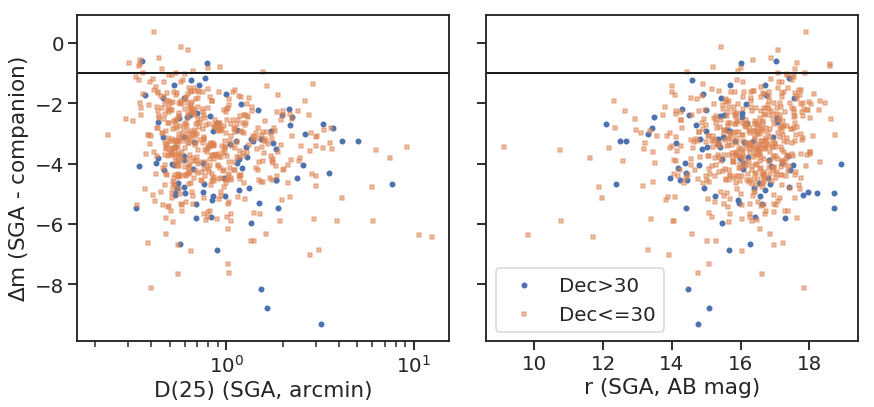

In [32]:
print(len(isga), len(isga)/len(fullsample))
fluxratio = ellipse_notsga['FLUX_R'][inotsga] / ellipse_sga['FLUX_R'][isga]
deltamag = 2.5 * np.log10(fluxratio)

#this = np.where(ellipse_sga['GALAXY'][isga] == 'PGC1630414')[0]
#cut = np.where(ellipse_sga['DEC'][isga] <= 30)[0]
#cut = np.where(ellipse_sga['DEC'][isga] > 30)[0]
nn = np.where(ellipse_sga['DEC'][isga] > 30)[0]
#nn = np.where((ellipse_sga['DEC'][isga] > 30) * (deltamag > -1))[0]
ss = np.where(ellipse_sga['DEC'][isga] <= 30)[0]
print(len(nn), len(ss))
cut = np.arange(len(isga))
print(len(cut))

sz = 10

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ax[0].scatter(ellipse_sga['DIAM'][isga][nn], 2.5*np.log10(fluxratio[nn]), 
              s=2*sz, label='Dec>30')
ax[0].scatter(ellipse_sga['DIAM'][isga][ss], 2.5*np.log10(fluxratio[ss]), 
              s=sz, label='Dec<=30', marker='s', alpha=0.5)
ax[0].axhline(y=-1, lw=2, color='k')
#ax[0].axhline(y=-0.5, lw=2, color='k')
ax[0].set_xscale('log')
ax[0].set_xlabel('D(25) (SGA, arcmin)')
ax[0].set_ylabel(r'$\Delta$m (SGA - companion)')

#ax[1].hexbin(22.5-2.5*np.log10(ellipse_sga['FLUX_R'][isga][cut]), np.log10(fluxratio[cut]), mincnt=1)
ax[1].scatter(22.5-2.5*np.log10(ellipse_sga['FLUX_R'][isga][nn]), 2.5*np.log10(fluxratio[nn]), 
              s=2*sz, label='Dec>30')
ax[1].scatter(22.5-2.5*np.log10(ellipse_sga['FLUX_R'][isga][ss]), 2.5*np.log10(fluxratio[ss]), 
              s=sz, label='Dec<=30', marker='s', alpha=0.5)
ax[1].axhline(y=-1, lw=2, color='k')
ax[1].set_xlabel('r (SGA, AB mag)')

ax[1].legend(loc='lower left')

fig.subplots_adjust(wspace=0.1)

In [33]:
def gather_closepairs():
    from astropy.table import Table, Column

    cut = np.arange(len(isga))
    #cut = np.where(ellipse_sga['DEC'][isga] <= 30)[0]
    #cut = np.where(ellipse_sga['DEC'][isga] > 30)[0]
    _isga = isga[cut]
    _inotsga = inotsga[cut]
    _fluxratio = fluxratio[cut]
    
    #ww = ellipse_sga[_isga]['GROUP_NAME'] == 'PGC1932070'
    #print(ellipse_sga[_isga]['GROUP_NAME'][ww], ellipse_sga[_isga]['FLUX_R'][ww], 
    #      ellipse_notsga[_inotsga]['FLUX_R'][ww], 2.5*np.log10(_fluxratio[ww]))

    I = np.where(np.argmax(np.vstack([ellipse_sga[_isga]['FLUX_R'], ellipse_notsga[_inotsga]['FLUX_R']]).T, axis=1) == 0)[0]
    J = np.where(np.argmax(np.vstack([ellipse_sga[_isga]['FLUX_R'], ellipse_notsga[_inotsga]['FLUX_R']]).T, axis=1) == 1)[0]

    out = Table()
    out['group'] = ellipse_sga[_isga]['GROUP_NAME']
    out['galaxy'] = ellipse_sga[_isga]['GALAXY']
    out['pgc'] = ellipse_sga[_isga]['PGC']
    out['brickname'] = ellipse_sga[_isga]['BRICKNAME']
    out['diam'] = ellipse_sga[_isga]['DIAM']
    out['group_diam'] = ellipse_sga[_isga]['GROUP_DIAMETER']
    out['type'] = ellipse_sga[_isga]['TYPE']
    out['fluxratio'] = _fluxratio
    out['deltamag'] = 2.5*np.log10(_fluxratio)
    out['sga_ra'] = ellipse_sga[_isga]['SGA_RA']
    out['sga_dec'] = ellipse_sga[_isga]['SGA_DEC']
    out['ra'] = ellipse_sga[_isga]['RA']
    out['dec'] = ellipse_sga[_isga]['DEC']
    out['ra'][J] = ellipse_notsga[_inotsga][J]['RA']
    out['dec'][J] = ellipse_notsga[_inotsga][J]['DEC']
    
    _, K = np.unique(out['galaxy'], return_index=True)
    out = out[K]
    
    return out    
fix = gather_closepairs()

/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log10


In [36]:
#fix[fix['galaxy'] == 'NGC5001']
#fix[np.argsort(fix['group_diam'])[::-1]]
#ww = np.where(fix['pgc'] == 1932070)[0]
#fix[ww]
bb = fix[fix['deltamag'] > -1]['galaxy', 'ra', 'dec', 'deltamag', 'group']
#bb = fix[fix['group_diam'] < 1]#['galaxy', 'ra', 'dec', 'deltamag']
bb
#bb['group',].write('closepairs.txt', format='ascii.basic', overwrite=True)
#bb = fix['galaxy', 'ra', 'dec']
#bb.rename_column('galaxy', 'GALAXY')
#bb.rename_column('ra', 'RA')
#bb.rename_column('dec', 'DEC')
#viewer_inspect(bb)

galaxy,ra,dec,deltamag,group
bytes29,float64,float64,float32,bytes35
2MASXJ15171364+3310069,229.30681041246106,33.16904207639382,-0.67743903,2MASXJ15171364+3310069
2MASXJ15175925+2652409,229.49676140402954,26.87803112709994,-0.80883235,2MASXJ15175925+2652409
PGC1009351,30.07189923979485,-8.031899898309783,-0.93098456,PGC1009351
PGC1033102,147.89923535850784,-6.415971169427825,-0.8373904,PGC1033102
PGC1214699,184.11492142217477,2.059562429538121,-0.13090712,PGC1214699
PGC1541561,223.6914222729757,17.783188708528797,-0.2314131,PGC1541561
PGC1932070,155.23636960109778,31.10896815999497,-0.59686404,PGC1932070
PGC3089838,353.3162025594473,22.941212408150825,-0.97975993,PGC3089838
PGC465433,9.835884015636756,-50.5402405385639,-0.710653,PGC465433


In [ ]:
stop

In [ ]:
#plt.hexbin(22.5-2.5*np.log10(ellipse_sga['FLUX_R'][isga]), np.log10(fluxratio), mincnt=1)
#plt.scatter(22.5-2.5*np.log10(ellipse_sga['FLUX_R'][isga][J]), np.log10(fluxratio[J]), s=1, color='orange')
#fix[(fix['fluxratio'] > 10) * (fix['dec'] > 30)]
#fix[fix['dec'] > 30]['galaxy', 'pgc', 'ra', 'dec'].write('newcoords.txt', format='ascii.basic', overwrite=True)
fix['galaxy', 'pgc', 'ra', 'dec']#.write('newcoords.txt', format='ascii.basic', overwrite=True)
#refit = fix[(fix['fluxratio'] >= 1) * (fix['dec'] >= 30)]
#refit = fix[(fix['dec'] > 30)]
refit = fix
#with open('south-tofix.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in set(refit['group'])]
#refit[refit['type'] == 'PSF']
refit#.write('north-tofix.fits')
#fix[fix['group'] == 'SDSSJ133324.93+492310.7']
#refit['galaxy', 'pgc', 'ra', 'dec'].write('newcoords.txt', format='ascii.basic', overwrite=True)

In [ ]:
ellipse[ellipse['GALAXY'] == 'SDSSJ072815.25+37563']

In [ ]:
tt = Table.read('junk.txt', format='ascii.basic')
ww = []
for gg in tt['galaxy']:
    _ww = np.where(ellipse['GALAXY'] == gg.strip())[0]
    if len(_ww) == 0:
        print(gg)
    else:
        ww.append(_ww)
ww = np.hstack(ww)
#ellipse[ww]['GALAXY', 'PGC', 'RA', 'DEC'].pprint(max_lines=-1)
#[print(gg.decode('utf-8')) for gg in set(ellipse[ww]['GROUP_NAME'].data)]

In [ ]:
def check_results(group):
    #print()
    from legacyhalos.SGA import get_galaxy_galaxydir
    cat = ellipse_sga[ellipse_sga['SGA_ID'] > -1] 
    galaxy, galaxydir = get_galaxy_galaxydir(cat[cat['GROUP_NAME'] == group][0])
    #print(galaxy, galaxydir)

    tractorfile = '{}/{}-largegalaxy-tractor.fits'.format(galaxydir, galaxy)
    #print(tractorfile)
    nn = Table.read(tractorfile)
    nr = nn[nn['ref_cat'] == 'L3']
    if len(nr) > 0:
        _, n2, nd = match_radec(nr['ra'], nr['dec'], nn['ra'], nn['dec'], 2./3600)
        nout = nn[n2]['type', 'ref_cat', 'ref_id', 'ra', 'dec', 'flux_r', 'shape_r']
        nout['dtheta'] = nd*3600
        this = nout[nout['ref_cat'] == 'L3']
        if np.any(this['type'] == 'PSF'):
            print('SGA source is PSF in {}'.format(tractorfile))
            nout.pprint(max_width=-1)
    else:
        print('SGA dropped from {}'.format(tractorfile))
    
for grp in refit['group']:
    check_results(grp)

In [ ]:
stop

In [ ]:
from legacyhalos.SGA import get_galaxy_galaxydir
galaxy, galaxydir = get_galaxy_galaxydir(ellipse[ellipse['GALAXY'] == refit['galaxy'][0]])
print(galaxy, galaxydir)

nn = Table.read('{}/{}-largegalaxy-tractor.fits'.format(galaxydir, galaxy))
nr = nn[nn['ref_cat'] == 'L3']
_, n2, nd = match_radec(nr['ra'], nr['dec'], nn['ra'], nn['dec'], 2./3600)
nout = nn[n2]['ref_cat', 'ref_id', 'ra', 'dec', 'type', 'flux_r', 'shape_r']
nout['dtheta'] = nd*3600
nout

In [ ]:
#gg = np.loadtxt()
#ww = (ellipse_sga['GROUP_DIAMETER'][isga] > 1) * (fluxratio > 1)
#ww = (ellipse_sga['DIAM'][isga] > 0.5) * (fluxratio > 0.1)
#wflux = np.where((fluxratio > 0.5))[0]# * (ellipse_sga['GROUP_DIAMETER'][isga] <3))[0]
#wflux = np.where((ellipse_sga['DIAM'][isga] > 0.5))[0]
wflux = np.where((ellipse_sga['DEC'][isga] < -30))[0]
print(len(wflux))
#wflux = np.where((ellipse_sga['GROUP_DIAMETER'][isga] <3))[0]
#viewer_inspect(ellipse_sga[isga][wflux])
#with open('newcoords.txt', 'w') as ff:
#    #[ff.write('{}\n'.format(gg)) for gg in set(ellipse_sga[isga][wflux]['GROUP_NAME'][np.argsort(ellipse_sga[isga][wflux]['DIAM'])[::-1]])]
#    for ii in wflux:
#        if ii % 100 == 0:
#            print(ii)
#        gal = ellipse_sga[isga][ii]['GALAXY']
#        pgc = ellipse_sga[isga][ii]['PGC']
#        ra = ellipse_sga[isga][ii]['RA']
#        dec = ellipse_sga[isga][ii]['DEC']
#        #print(gal, pgc, ra, dec, ellipse_sga[isga][ii]['SGA_RA'], ellipse_sga[isga][ii]['SGA_DEC'])
#        ff.write('{} {} {} {}\n'.format(gal, pgc, ra, dec))
#ellipse_sga[isga][wflux][np.argsort(ellipse_sga[isga][wflux]['DIAM'])[::-1]]
_ = plt.hist(ellipse_sga[isga][wflux]['DIAM'], bins=100, range=(-0.1, 3.5))

In [ ]:
stop

### Sandbox code below here!

In [ ]:
#ww = np.where(fluxratio > 0.1)[0]
fig, ax = plt.subplots(figsize=(10, 8))
#ax.scatter(ellipse_sga['RA'][isga], ellipse_sga['DEC'][isga], s=5, 
#           label='All (N={})'.format(len(isga)))
ax.scatter(ellipse_sga['RA'][isga][wflux], ellipse_sga['DEC'][isga][wflux], s=5, 
           label='Fluxratio>0.1 (N={})'.format(len(wflux)), marker='x', alpha=0.5)
ax.invert_xaxis()
ax.legend(fontsize=14)

In [ ]:
def delta_size_rmag(cat, delta=False):
    from astropy.table import Table, vstack
    from legacyhalos.SGA import get_galaxy_galaxydir
    galaxy, galaxydir = get_galaxy_galaxydir(cat)
    
    if delta:
        outfile = 'dr9alpha-dr9delta.fits'
    else:
        outfile = 'dr9alpha-dr9beta.fits'
            
    if os.path.isfile(outfile):
        out = Table.read(outfile)
        print('Read {} galaxies from {}'.format(len(out), outfile))
    else:
        out = []
        for ii, (gal, gdir) in enumerate(zip(np.atleast_1d(galaxy), np.atleast_1d(galaxydir))):
            if ii % 50 == 0:
                print(ii)
            oldfile = os.path.join(gdir, '{}-largegalaxy-tractor.fits'.format(gal))
            if delta:
                newfile = os.path.join(gdir.replace('alpha', 'delta'), '{}-largegalaxy-tractor.fits'.format(gal))
            else:
                newfile = os.path.join(gdir.replace('alpha', 'beta'), '{}-largegalaxy-tractor.fits'.format(gal))
                
            #print(oldfile, newfile)
            if os.path.isfile(oldfile) and os.path.isfile(newfile):
                old = fitsio.read(oldfile, columns='ref_id')
                new = fitsio.read(newfile, columns='ref_id')
            
                I = np.where(old == cat['SGA_ID'][ii])[0]
                J = np.where(new == cat['SGA_ID'][ii])[0]
                if len(I) != 1 or len(J) != 1:
                    print('Problem with {}'.format(gdir))
                else:
                    try:
                        old = fitsio.read(oldfile, rows=I, columns=['flux_r', 'shape_r', 'type', 'ra', 'dec', 'ref_id'])
                        new = fitsio.read(newfile, rows=J, columns=['flux_r', 'shape_r', 'type', 'ra', 'dec', 'ref_id'])
                    except:
                        #pdb.set_trace()
                        print('Problem with {}'.format(oldfile))
            
                    out1 = Table()
                    out1['galaxy'] = [gal]
                    out1['ra'] = new['ra'][0]
                    out1['dec'] = new['dec'][0]
                    out1['sga_id'] = new['ref_id'][0]
                    out1['type_new'] = new['type'][0]
                    out1['type_old'] = old['type'][0]
                    out1['rmag_new'] = 22.5-2.5*np.log10(new['flux_r'][0])
                    out1['rmag_old'] = 22.5-2.5*np.log10(old['flux_r'][0])
                    out1['r50_new'] = new['shape_r'][0]
                    out1['r50_old'] = old['shape_r'][0]
                    out.append(out1)
        out = vstack(out)
        print('Writing {} galaxies to {}'.format(len(out), outfile))
        out.write(outfile, overwrite=True)

    return out

In [ ]:
#%time beta = delta_size_rmag(ellipse_sga[isga], delta=False)
%time out = delta_size_rmag(ellipse_sga[isga][wflux], delta=True)
big = out['r50_new']/out['r50_old'] > 1.2
#out[big]
' '.join(out[big]['galaxy'].data)

In [ ]:
beta[beta['type_old'] == 'PSF']

In [ ]:
out[out['galaxy'] == 'NGC2191']
#ipsf = np.where(out['type_new'] == 'PSF')[0]
#out[ipsf]

In [ ]:
this = np.where(out['galaxy'] == 'PGC1630414')[0]
ipsf = np.where((out['type_new'] == 'PSF') * (out['type_old'] != 'PSF'))[0]
sz = 50 # 1

dmag = out['rmag_new'] - out['rmag_old']
dsize = out['r50_new']/out['r50_old']

fig, ax = plt.subplots(2, 2, figsize=(12, 12))#, sharey=True)

ax[0, 0].scatter(out['rmag_new'], out['rmag_old'], s=sz)
ax[0, 0].scatter(out['rmag_new'][ipsf], out['rmag_old'][ipsf], s=sz, color='red')
ax[0, 0].scatter(out['rmag_new'][this], out['rmag_old'][this], s=50, marker='x', color='yellow')
ax[0, 0].plot([10, 25], [10, 25], color='k', ls='--')
ax[0, 0].set_xlim(25, 10)
ax[0, 0].set_ylim(25, 10)
ax[0, 0].set_xlabel(r'$r$ (dr9delta, AB mag)')
ax[0, 0].set_ylabel(r'$r$ (dr9alpha, AB mag)')

ax[0, 1].scatter(np.log10(out['r50_new']), np.log10(out['r50_old']), s=sz)
ax[0, 1].scatter(np.log10(out['r50_new'][ipsf]), np.log10(out['r50_old'][ipsf]), s=sz, color='red')
ax[0, 1].scatter(np.log10(out['r50_new'][this]), np.log10(out['r50_old'][this]), s=50, marker='x', color='yellow')
ax[0, 1].set_xlabel(r'$\log(r_{50})$ (dr9delta, arcsec)')
ax[0, 1].set_ylabel(r'$\log(r_{50})$ (dr9alpha, arcsec)')
ax[0, 1].set_xlim(-1, 3)
ax[0, 1].set_ylim(-1, 3)
ax[0, 1].plot([-1, 3], [-1, 3], color='k', ls='--')

ax[1, 0].scatter(dsize, dmag, s=sz)
ax[1, 0].scatter(dsize[ipsf], dmag[ipsf], s=sz, color='red')
ax[1, 0].scatter(dsize[this], dmag[this], s=50, marker='x', color='yellow')
ax[1, 0].set_ylabel(r'$\Delta r$ (dr9delta-dr9alpha, AB mag)')
ax[1, 0].set_xlabel(r'$(r_{50, dr9delta}\ /\ r_{50, old})$')
ax[1, 0].axhline(y=0, lw=2, ls='--', color='k', alpha=0.8)
ax[1, 0].axvline(x=1, lw=2, ls='--', color='k', alpha=0.8)
ax[1, 0].set_ylim(-5, 5)

ax[1, 1].scatter(out['r50_new'], dmag, s=sz)
ax[1, 1].scatter(out['r50_new'][ipsf], dmag[ipsf], s=sz, color='red')
ax[1, 1].scatter(out['r50_new'][this], dmag[this], s=50, marker='x', color='yellow')
ax[1, 1].set_ylabel(r'$\Delta r$ (dr9delta-dr9alpha, AB mag)')
ax[1, 1].set_xlabel(r'$r_{50}$ (dr9delta, arcsec)')
ax[1, 1].axhline(y=0, lw=2, ls='--', color='k', alpha=0.8)
ax[1, 1].set_ylim(-5, 5)

fig.subplots_adjust(wspace=0.25)
#out

In [ ]:
ipsf = np.where(out['type_new'] == 'PSF')[0]
if False:
    _out = out[ipsf]['galaxy', 'ra', 'dec']
    _out.rename_column('galaxy', 'name')
    _out.write('viewer.fits', overwrite=True)#, format='ascii.basic', 
#plt.scatter(out['ra'][ipsf], out['dec'][ipsf], s=10)

gg = np.unique(np.intersect1d(ellipse_sga[isga]['GROUP_NAME'], out['galaxy']))

w1 = np.where(np.isin(out['galaxy'], gg))[0]
w2 = np.where(np.isin(ellipse_sga[isga]['GROUP_NAME'], gg))[0]
print(len(w1), len(w2))
print(np.max(fluxratio[w1]))

plt.scatter(out['r50_new'][w1]/out['r50_old'][w1], fluxratio[w2])

#ellipse_sga[isga][ww]

In [ ]:
check = np.where(out['r50_new']/out['r50_old'] > 2)[0]
#out[check]['galaxy', 'ra', 'dec']
out[check]['galaxy',].write('dr9beta-bigger.txt', format='ascii.basic')

In [ ]:
print(len(out))
sample[np.isin(sample['GROUP_NAME'], out['galaxy'])]
#out[ipsf]['galaxy', 'ra', 'dec']

In [ ]:
nn = Table.read('/global/cscratch1/sd/ioannis/SGA-data-dr9delta/133/PGC1588014/PGC1588014-largegalaxy-tractor.fits')
nr = nn[nn['ref_cat'] == 'L3']
_, n2, nd = match_radec(nr['ra'], nr['dec'], nn['ra'], nn['dec'], 2./3600)
nout = nn[n2]['ref_cat', 'ref_id', 'ra', 'dec', 'type', 'flux_r', 'shape_r']
nout['dtheta'] = nd*3600
nout

In [ ]:
nn = Table.read('/global/cscratch1/sd/ioannis/SGA-data-dr9alpha/133/PGC1588014/PGC1588014-largegalaxy-tractor.fits')
nr = nn[nn['ref_cat'] == 'L3']
_, n2, nd = match_radec(nr['ra'], nr['dec'], nn['ra'], nn['dec'], 2./3600)
nout = nn[n2]['ref_cat', 'ref_id', 'ra', 'dec', 'type', 'flux_r', 'shape_r']
nout['dtheta'] = nd*3600
nout

In [ ]:
stop

In [ ]:
#ww = ellipse_sga['SHAPE_R'][isga]/60 > 1
ww = np.where(fluxratio > 1)[0][:5]
print(ellipse_sga['GALAXY', 'RA', 'DEC', 'FLUX_R', 'TYPE', 'SHAPE_R'][isga[ww]])
print(ellipse_notsga['GALAXY', 'RA', 'DEC', 'FLUX_R', 'TYPE', 'SHAPE_R'][inotsga[ww]])

In [ ]:
ellipse_notsga['GALAXY', 'RA', 'DEC', 'FLUX_R', 'TYPE', 'SHAPE_R'][inotsga[0]]

In [ ]:
stop

#### SGA galaxies that are close to one another

In [ ]:
ellipse_sga = ellipse[(ellipse['SGA_ID'] > -1) * ellipse['PREBURNED']]

def close_sga_pairs():
    I = match_radec(ellipse_sga['RA'], ellipse_sga['DEC'], ellipse_sga['RA'],
                    ellipse_sga['DEC'], 2./3600., indexlist=True)

    dupsga = []
    for ii, jj in enumerate(I):
        if len(jj) == 1:
            continue
        dupsga.append(ii)
    dupsga = np.array(dupsga)
    
    #with open('closepairs.txt', 'w') as ff:
    #    [ff.write('{}\n'.format(gg)) for gg in set(ellipse_sga['GROUP_NAME'][isga])]    
        
    return dupsga

dupsga = close_sga_pairs()

In [ ]:
ellipse_sga[dupsga]
#_ = plt.hist(ellipse_sga[dupsga]['DIAM'], bins=50)

#### Delta-coordinates between SGA and SGA-parent

In [ ]:
ww = np.where(ellipse['PREBURNED']*(ellipse['SGA_ID'] >= 0))[0]
dd = []
for w2 in ww:
    dd.append(arcsec_between(ellipse['RA'][w2], ellipse['DEC'][w2], 
                              ellipse['SGA_RA'][w2], ellipse['SGA_DEC'][w2]))
dd = np.array(dd)

In [ ]:
print(np.max(dd), np.min(dd), np.mean(dd), np.median(dd), np.std(dd), np.sum(dd>2), len(dd), np.sum(dd>2)/len(dd))
_ = plt.hist(dd, bins=100, range=(0, 20))
plt.yscale('log')
plt.xlabel('Delta-RA,Dec [Tractor minus SGA-parent]')
#plt.scatter(dd, ellipse['DIAM'][ww], s=30)
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
w2 = ww[(dd > 5)*(dd < 10)][118:]
w2 = w2[np.argsort(ellipse[w2]['DIAM'])[::-1]]
ellipse[w2]['GALAXY', 'SGA_RA', 'SGA_DEC', 'RA', 'DEC', 'ELLIPSEBIT', 'DROPBIT', 'DIAM']
viewer_inspect(ellipse[w2])

#### Code to determine which chunks to rerun.

Building the SGA is done in chunks of 1024 galaxies. The code below determines which *chunk* a galaxy belongs to so that chunk can be rerun (e.g., if a fitting problem is addressed) without having to redo everything. 

Note: the function `get_groupchunk` is excised from `legacyhalos/bin/SGA/SGA-mpi`.

In [ ]:
def get_groupchunk(sample, galaxylist, bigchunksize=1024, rank=0, size=1):
    from legacyhalos.SGA import get_galaxy_galaxydir
    samp = sample[np.argsort(sample['GROUP_ID'])] # sort by group_id
        
    nbigchunks = np.ceil(len(samp) / bigchunksize).astype(np.int)
    bigchunks = np.array_split(np.arange(len(samp)), nbigchunks)
    groups = np.array_split(bigchunks, size)
    mingrp, maxgrp = [], []
    for ichunk, chunk in enumerate(groups[rank]):
        mingrp.append(np.min(samp['GROUP_ID'][chunk]))
        maxgrp.append(np.max(samp['GROUP_ID'][chunk]))
    mingrp = np.array(mingrp)
    maxgrp = np.array(maxgrp)
    
    chunkdirs = []
    for galaxy in galaxylist:
        thisgal = samp[samp['GROUP_NAME'] == galaxy]
        #if len(thisgal) == 0:
        #    print(galaxy)
        #    import pdb ; pdb.set_trace()
        gg, gdir = get_galaxy_galaxydir(thisgal)
        grz = os.path.join(gdir, '{}-largegalaxy-image-grz.jpg'.format(gg))
        if os.path.isfile(grz):
            grp = thisgal['GROUP_ID']
            I = np.where((grp >= mingrp) * (grp <= maxgrp))[0][0]
            #import pdb ; pdb.set_trace()
            chunkdir = '{}-{}'.format(mingrp[I], maxgrp[I])
            #print(chunkdir)
            chunkdirs.append(chunkdir)
    return np.array(chunkdirs)

In [ ]:
#galaxylist = np.hstack((dropcat[notfit]['GALAXY'], 'PGC1018114'))
#galaxylist = dropcat[notfit]['GALAXY']
#galaxylist = dropcat[other]['GALAXY'].data.astype(str)
#print(len(galaxylist), galaxylist)
#galaxylist = np.array(['PGC613968', 'IC5154', 'PGC141889', 'PGC063891', 'PGC163580',
#       'PGC630029', 'PGC613953', 'PGC131809', 'PGC1172540', 'ESO341-018',
#       'PGC605764', 'NGC0598', 'PGC630226', 'PGC1551457', 'PGC131800',
#       'PGC070119', 'PGC1978246', 'PGC131797', 'PGC640298', 'PGC186631',
#       'ESO342-054'])
#redo = get_groupchunk(sample, galaxylist)
#for rr in redo:
#    print('rm -rf {}'.format(os.path.join(os.getenv('LEGACYHALOS_DATA_DIR'), 'chunks', rr)))

In [ ]:
tt = Table.read('/global/cscratch1/sd/raichoor/tmpdir/tmp.fits')
#srt = np.argsort(tt['GROUP_DIAMETER'])[::-1]
#tt['GROUP_NAME', 'GROUP_DIAMETER'][srt]
galaxylist = np.array(list(set(np.hstack((
    tt['GROUP_NAME'].data,                             
    dropcat[other]['GROUP_NAME'].data, 
    'UGC03474_GROUP',
    'NGC3978_GROUP',
    'UGC05459')))))
keep = np.where(np.logical_not(np.isin(galaxylist, ['UGC08614', 'KKR25', 'PGC772322', 'PGC768010'])))[0]
galaxylist = galaxylist[keep]
#print(galaxylist)
redo = get_groupchunk(sample, galaxylist)
print(len(galaxylist), len(redo))
#for rr in redo:
#    print('rm -rf {}'.format(os.path.join(os.getenv('LEGACYHALOS_DATA_DIR'), 'chunks', rr)))

In [ ]:
ellipse[ww][dd > 5]['GALAXY', 'SGA_RA', 'SGA_DEC', 'RA', 'DEC', 'ELLIPSEBIT', 'DROPBIT']
viewer_inspect(ellipse[ww][dd > 5])

In [ ]:
w3 = ww[(dd > 2)*(ellipse[ww]['GROUP_DIAMETER'] > 2)]
bb = ellipse[w3]
bb
#with open('badcoords.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in set(bb['GROUP_NAME'])]

In [ ]:
if False:
    import subprocess
    from legacyhalos.SGA import get_galaxy_galaxydir
    bb = ellipse[ww][(dd > 2)*(ellipse[ww]['GROUP_DIAMETER'] > 2)]
    for onegal in bb:
        gal, gdir = get_galaxy_galaxydir(onegal)
        cmd = 'ls -l {}/{}-largegalaxy-image-grz.jpg'.format(gdir, gal, gal)
        rr = subprocess.check_output(cmd, shell=True, universal_newlines=True).strip()
        print(rr)

In [ ]:
bb = ellipse[ww][(dd > 2)*(ellipse[ww]['GROUP_DIAMETER'] > 2)]
viewer_inspect(bb)
#imagetool_inspect(bb)
#bb[bb['GALAXY'] == 'NGC0840']['RA', 'DEC', 'SGA_RA', 'SGA_DEC']
#with open('badcoords.txt', 'w') as ff:
#    [ff.write('{}\n'.format(gg)) for gg in set(bb['GROUP_NAME'])]

### Utility functions - useful!

In [ ]:
def newgroup(galaxy, action):
    # action 0 = do nothing; 1 = remove; 2 = fixed coordinates or diameter (refit)
    group = fullsample[fullsample['GALAXY'] == galaxy]
    if len(group) == 0:
        print('No galaxy {}'.format(galaxy))
        return None
    groupname = group['GROUP_NAME'][0]
    if action == 2:
        return groupname
    if action == 1:
        members = fullsample[(fullsample['GROUP_NAME'] == groupname) * (fullsample['GALAXY'] != galaxy)]
        if len(members) == 1:
            groupname = members['GALAXY'][0]
        elif len(members) > 0:
            # more than one member, so refit
            groupname = '{}_GROUP'.format(members[np.argmax(members['D25_LEDA'])]['GALAXY'])
        return groupname        
    return None

In [ ]:
newgroup('PGC574106', 1)

In [ ]:
tt = Table.read('tmp/arjun.txt', format='ascii.basic')
tt[:4]

In [ ]:
refit = []
for gg, aa in zip(tt['name'], tt['action']):
    ngg = newgroup(gg, aa)
    if ngg:
        refit.append(ngg)
refit = np.array(refit)
print(len(refit))
#print(refit)
with open('refit.txt', 'w') as ff:
    [ff.write('{}\n'.format(gg)) for gg in set(refit)]

In [ ]:
#ellipse[(ellipse['GROUP_NAME'] == 'NGC4406_GROUP')*(ellipse['SGA_ID']>-1)]#['SGA_RA', 'SGA_DEC', 'RA', 'DEC', 'DIAM', 'ELLIPSEBIT', 'DROPBIT', 'PREBURNED', 'FREEZE']
fullsample[fullsample['GROUP_NAME'] == 'NGC4406_GROUP']

In [ ]:
ww = (ellipse['SGA_ID'] != -1) * (ellipse['DIAM'] > 5) * (ellipse['PREBURNED'])
viewer_inspect(ellipse[ww])
ellipse[ww]

In [ ]:
ellipse[(ellipse['REF_CAT'] == 'L3') * (ellipse['SGA_ID'] == -1)]['GALAXY', 'RA', 'DEC', 'SGA_ID', 'REF_ID', 'TYPE']

In [ ]:
from legacyhalos.SGA import VETO_ELLIPSE
print(len(VETO_ELLIPSE))
#ww = [np.where(fullsample['GALAXY'] == vv)[0] for vv in VETO_ELLIPSE]
ww = np.hstack([np.where(fullsample['GALAXY'] == vv)[0] for vv in VETO_ELLIPSE])
#for vv in VETO_ELLIPSE:
#    if len(np.where(fullsample['GALAXY'] == vv)[0]) == 0:
#        print(vv)
#print(ww)
#fullsample[ww]
viewer_inspect(fullsample[ww])

In [ ]:
print(VETO_ELLIPSE)

In [ ]:
fullsample[fullsample['GROUP_NAME'] == 'NGC4406_GROUP']

In [ ]:
isga = np.where(ellipse['SGA_ID'] > -1)[0]
notsga = np.where(ellipse['SGA_ID'] < -1)[0]
m1, m2, _ = match_radec(ellipse['RA'][isga], ellipse['RA'][isga], 
                        

In [ ]:
from astrometry.libkd.spherematch import match_radec, tree_build_radec, tree_search_radec, trees_match, tree_open

#J = np.where((ellipse['SGA_ID'] == -1) * ellipse['PREBURNED'])[0]


kd = tree_open(kdellipsefile)
isga = np.where((ellipse['SGA_ID'] > -1) * ellipse['PREBURNED'])[0]

sga = tree_build_radec(ellipse[isga]['RA'], ellipse[isga]['DEC'])
I, J, dd = trees_match(kd, sga, np.radians(3.0/3600))

In [ ]:
help(trees_match)

In [ ]:
J = np.where(ellipse['GROUP_NAME'] == 'PGC1630414')[0]
m1, m2, d12 = match_radec(ellipse['RA'][J], ellipse['DEC'][J], ellipse['RA'], 
                        ellipse['DEC'], 1.0/3600.0, nearest=False)
print(d12*3600)

In [ ]:
#ellipse[m2]['GALAXY', 'RA', 'DEC', 'FLUX_R']
print(22.5-2.5*np.log10(ellipse[J]['FLUX_R'].data))
ellipse[J]['GALAXY', 'SGA_ID', 'OBJID', 'RA', 'DEC', 'FLUX_R', 'SHAPE_R', 'TYPE', 'PREBURNED']

In [ ]:
tt = Table.read('/global/cscratch1/sd/ioannis/SGA-data-dr9alpha/test-bugs/215/PGC1630414/PGC1630414-largegalaxy-tractor.fits')
k1, k2, _ = match_radec(ellipse['RA'][J], ellipse['DEC'][J], tt['ra'], tt['dec'], 1.0/3600.0, nearest=False)
_, uu = np.unique(k2, return_index=True)
tt[k2][uu]['objid', 'ref_id', 'ra', 'dec', 'flux_r', 'shape_r', 'type']

In [ ]:
22.5-2.5*np.log10([84.51427, 56.80053, 0.5927692])

In [ ]:
help(match_radec)

In [ ]:
ellipse

In [ ]:
help(match_radec)